In [4]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from ipywidgets import interact

from scipy.interpolate import UnivariateSpline

In [5]:
rhom = 8.92e3 # mass density of copper
rho = 1.7e-8 # resistivity of copper
h = 1e-3 # thickness of plate

N_rings = 500 # number of rings for flux calculation
rmax = 0.1 # radius of circular plate
dr = rmax / N_rings

m = rhom * rmax*rmax*np.pi * h # mass of copper plate

B = 0.1 # strength of magnetic field for x > 0

x0 = -0.1 # initial position of plate
v0 = 0.1 # initial velocity in x direction

# define time and position arrays
N_steps = 100 # number of steps for simulation
tmax = 2 # time range for simulation
dt = tmax/N_steps
t = np.linspace(0, tmax, N_steps)

x = x0 + v0*t

# calculate areas as function of position
A = np.zeros((N_steps, N_rings))
A0 = np.zeros(N_rings)

rs = np.linspace(dr, rmax, N_rings) # outer radii of rings

A0 = rs*rs*np.pi # areas of complete discs

# loop to calculate partial areas in magnetic field
for i, pos in enumerate(x):
    for j, r in enumerate(rs):
        if pos < 0:
            if pos + r > 0:
                s = np.sqrt(r*r - pos*pos)
                al = np.arccos(-pos/r)
                A[i, j] = A0[j]*al/np.pi + s*pos
        if pos > 0:
            if pos - r < 0:
                s = np.sqrt(r*r - pos*pos)
                al = np.arccos(pos/r)
                A[i, j] = A0[j]*(1-al/np.pi) + s*pos
            else:
                A[i, j] = A0[j]

# define interpolated functions for areas and rate of change of areas

areas = [UnivariateSpline(x, A[:, i], k=3, s=0) for i in range(N_rings)]
dadxs = [areas[i].derivative() for i in range(N_rings)]

# for i, area in enumerate(areas):
#     # plt.plot(x, area(x))
#     # plt.plot(x, A[:, i])
#     plt.plot(x, area(x)-A[:, i])
# for dadx in dadxs:    
#     plt.plot(x, dadx(x))
# plt.show()

# define quantities for calculation of force
x = np.zeros(N_steps) # define empty array for positions
vx = np.zeros(N_steps) # define empty array for velocities
x[0] = x0 # initial position
vx[0] = v0 # initial velocity

Rs = rho*2*np.pi*(rs-dr/2)/(dr*h) # resistance of rings

N_segments = 120 # number of segments per ring
phis = np.linspace(0, 2*np.pi, N_segments) # angles

# define vectors for segments
rxs = [rs[i] * np.sin(phis) for i in range(N_rings)]
rys = [rs[i] * np.cos(phis) for i in range(N_rings)]
rzs = np.zeros((N_rings, N_segments))

r_vecs = np.array([rxs, rys, rzs])

F = np.zeros((N_rings, 3)) # initialize force array
B_vec = np.array([0, 0, B]) # magnetic field vector

# loop to calculate positions
for i in range(N_steps-1):
    Eis = [min(-B*dadxs[j](x[i])*vx[i], 0) for j in range(N_rings)] # induced emf (Faraday's law)
    Is = Eis/Rs # calculate currents through rings

    for j in range(N_rings):
        rj = np.copy(r_vecs[:, j, :])
        rjx = np.delete(rj[0, :], np.where(rj[0, :]<0))
        rjy = np.delete(rj[1, :], np.where(rj[0, :]<0))
        
        dl = np.array([np.diff(rjx), np.diff(rjy)]) # line elements in field
        
        F[j] = -Is[j]*np.cross(dl, B_vec, axisa=0).sum(axis=0) # force on segment

    Fres = F.sum(axis=0) # resultant force
    ax = Fres[0]/m # acceleration in x direction

    vx[i+1] = vx[i] + ax*dt
    x[i+1] = x[i] + vx[i+1]*dt

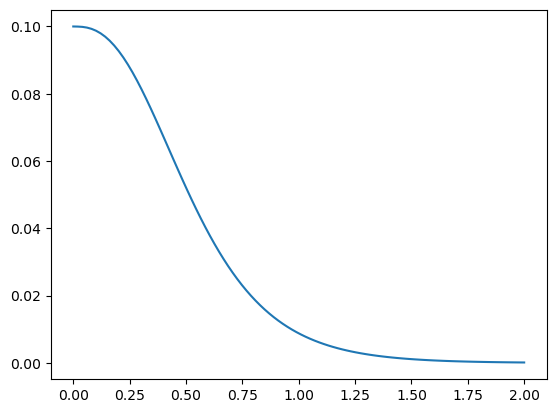

In [8]:
plt.plot(t, vx)
# plt.plot(t, x)
plt.show()

In [9]:
vx[-1]

0.0001403979334252555

In [91]:
vx[-1]

0.002889248367620174